In [1]:
import pandas as pd
import re
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

2024-07-29 17:56:33.644664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 17:56:33.644771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 17:56:33.779907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install peft

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 5.8 MB/s eta 0:00:00


In [3]:
data=pd.read_csv('/kaggle/input/mydataset/labeled_data.csv')
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
# data=data.iloc[:100]

# Cleaning the Text

In [5]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

   

In [6]:
data['clean_text']=data['tweet'].apply(lambda x:clean_text(x))

In [7]:
data=data[['clean_text','class']]

In [8]:
data

,clean_text,class
0,rt as a woman you shouldnt complain about cl...,2
1,rt boy dats coldtyga dwn bad for cuffin dat ...,1
2,rt dawg rt you ever fuck a bitch and she st...,1
3,rt she look like a tranny,1
4,rt the shit you hear about me might be true ...,1
...,...,...
24778,yous a muthafin lie right his tl is trash ...,1
24779,youve gone and broke the wrong heart baby and ...,2
24780,young buck wanna eat dat nigguh like i aint fu...,1
24781,youu got wild bitches tellin you lies,1


In [9]:
data=data.rename(columns={'class':'labels'})

In [10]:
import torch 
import torch.nn as nn

In [11]:
import torch
from torch import nn
from transformers import GPT2ForSequenceClassification
from transformers import GPT2Config

class GPTModel(nn.Module):
    def __init__(self, num_labels):
        super(GPTModel, self).__init__()
        configuration = GPT2Config()
        self.gpt = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=num_labels)
        self.gpt.config.pad_token_id = self.gpt.config.eos_token_id
        self.classifier = nn.Sequential(
            nn.Linear(self.gpt.config.hidden_size, num_labels),
            nn.ReLU()
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        return probabilities




# import torch
# from torch import nn
# from transformers import GPT2ForSequenceClassification, GPT2Tokenizer

# class GPTModel(nn.Module):
#     def __init__(self, num_labels):
#         super(GPTModel, self).__init__()
#         self.gpt = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=num_labels)
      

#     def forward(self, input_ids, attention_mask):
#         outputs = self.gpt(input_ids=input_ids, attention_mask=attention_mask)
#         return outputs.logits
 


 


In [12]:
data

,clean_text,labels
0,rt as a woman you shouldnt complain about cl...,2
1,rt boy dats coldtyga dwn bad for cuffin dat ...,1
2,rt dawg rt you ever fuck a bitch and she st...,1
3,rt she look like a tranny,1
4,rt the shit you hear about me might be true ...,1
...,...,...
24778,yous a muthafin lie right his tl is trash ...,1
24779,youve gone and broke the wrong heart baby and ...,2
24780,young buck wanna eat dat nigguh like i aint fu...,1
24781,youu got wild bitches tellin you lies,1


In [13]:
# data=data.iloc[:1000]

In [14]:
from sklearn.model_selection import train_test_split


In [15]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['labels'])

# Split the train + validation data into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42, stratify=train_val_data['labels'])

# Print the sizes of the splits
print(f'Training set size: {train_data.shape[0]}')
print(f'Validation set size: {val_data.shape[0]}')
print(f'Testing set size: {test_data.shape[0]}')

Training set size: 14869
Validation set size: 4957
Testing set size: 4957


In [16]:
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [17]:
from torch.utils.data import Dataset,DataLoader

In [18]:
 

# class HateSpeechDataset(Dataset):
#     def __init__(self, data, target, tokenizer, max_len):
#         self.data = data
#         self.target = target
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         sample = self.data.iloc[index]
#         encoding = self.tokenizer.encode_plus(
#             sample,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             truncation=True,
#             return_token_type_ids=False,
#             pad_to_max_length=True,
#             return_attention_mask=True,
#             return_tensors='pt'
#         )

#         return {
#             'sample': sample,
#             'input_id': encoding['input_ids'].flatten(),
#             'attention_mask': encoding['attention_mask'].flatten(),
#             'target': torch.tensor(self.target[index], dtype=torch.long)
#         }


class HateSpeechDataset(Dataset):
    def __init__(self, data, target, tokenizer, max_len):
        self.data = data
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data.iloc[index]
        encoding = self.tokenizer.encode_plus(
            sample,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',  # Use padding='max_length' instead of pad_to_max_length
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if len(input_ids) == 0:
            input_ids = torch.zeros(self.max_len, dtype=torch.long)
            attention_mask = torch.zeros(self.max_len, dtype=torch.long)

        return {
            'sample': sample,
            'input_id': input_ids,
            'attention_mask': attention_mask,
            'target': torch.tensor(self.target.iloc[index], dtype=torch.long)
        }






In [19]:
from transformers import GPT2Tokenizer

In [20]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [21]:
test_data.columns

Index(['clean_text', 'labels'], dtype='object')

In [22]:
train_dataset=HateSpeechDataset(train_data['clean_text'],train_data['labels'],gpt2_tokenizer,150)
test_dataset=HateSpeechDataset(test_data['clean_text'],test_data['labels'],gpt2_tokenizer,150)
val_dataset=HateSpeechDataset(val_data['clean_text'],val_data['labels'],gpt2_tokenizer,150)

In [23]:

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [24]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
learning_rate = 0.0001
EPOCHS = 5
num_labels=3

gpt2_model = GPTModel(num_labels)
gpt2_model = gpt2_model.to(device)

total_steps = len(train_data) * EPOCHS

criterian = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(params = gpt2_model.parameters(),lr = learning_rate)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def train_model(model, data_loader, criterian, optimizer):

    model.train()
    train_loss = 0.0
    correct_pred = 0
    total_preds = 0

    for d in data_loader:
        input_ids = d['input_id'].to(device)
        attention_masks = d['attention_mask'].to(device)
        targets = d['target'].to(device)
#         print('targets',targets)

        # forward prop
        predictions = model(input_ids , attention_masks)
#         print('preds',predictions)
#         targets = torch.argmax(targets, dim=1)
        
        loss = criterian(predictions, targets)
#         print('loss:',loss)
        _, pred_classes = torch.max(predictions, dim=1)

        #backprop
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # hack to avoid gradient explosion
        optimizer.step()
     
        optimizer.zero_grad()

        train_loss += loss.item()
        correct_pred += torch.sum(pred_classes == targets)
        total_preds += targets.size(0)

    accuracy = correct_pred.double() / total_preds
    avg_train_loss = train_loss / total_preds

    return accuracy, avg_train_loss

In [27]:



# def eval_model(model, data_loader, criterian):
#     model.eval()
#     eval_loss = 0.0
#     correct_pred = 0
#     total_preds = 0

#     with torch.no_grad():
#         for d in data_loader:
#             input_ids = d['input_id'].to(device)
#             attention_masks = d['attention_mask'].to(device)
#             targets = d['target'].to(device)

#             # forward prop
#             predictions = model(input_ids, attention_masks)
#             loss = criterian(predictions, targets)
#             _, pred_classes = torch.max(predictions, dim=1)

#             eval_loss += loss.item()
#             correct_pred += torch.sum(pred_classes == targets)
#             total_preds += targets.size(0)

#     accuracy = correct_pred.double() / total_preds
#     avg_eval_loss = eval_loss / total_preds

#     return accuracy, avg_eval_loss

In [28]:
from sklearn.metrics import precision_recall_fscore_support

def eval_model(model, data_loader, criterian):
    model.eval()
    eval_loss = 0.0
    correct_pred = 0
    total_preds = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_id'].to(device)
            attention_masks = d['attention_mask'].to(device)
            targets = d['target'].to(device)

            # forward pass
            predictions = model(input_ids, attention_masks)
            loss = criterian(predictions, targets)
            _, pred_classes = torch.max(predictions, dim=1)

            eval_loss += loss.item()
            correct_pred += torch.sum(pred_classes == targets)
            total_preds += targets.size(0)

            # Collect all predictions and targets
            all_preds.extend(pred_classes.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = correct_pred.double() / total_preds
    avg_eval_loss = eval_loss / total_preds
    
    # Compute precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')

    return accuracy, avg_eval_loss, precision, recall, f1


In [29]:
# from collections import defaultdict

# history = defaultdict(list)
# best_accuracy = 0
# EPOCHS = 10

# for epoch in range(EPOCHS):
#     print(f'epoch : {epoch+1}/{EPOCHS}')
#     train_acc , train_loss = train_model(gpt2_model,
#                                          train_loader,
#                                          criterian,
#                                          optimizer)

#     val_acc , val_loss = eval_model(gpt2_model,
#                                     val_loader,
#                                     criterian)

#     history['train_acc'].append(train_acc)
#     history['train_loss'].append(train_loss)
#     history['val_acc'].append(val_acc)
#     history['val_loss'].append(val_loss)

#     print(f'train_loss: {train_loss}, train_acc: {train_acc} ,val_loss: {val_loss}, val_acc: {val_acc}')
#     if val_acc > best_accuracy:
#         best_model_name = f'best_model_state.bin'
#         torch.save(gpt2_model.state_dict(), best_model_name)
#         best_accuracy = val_acc

In [30]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f'epoch : {epoch+1}/{EPOCHS}')
    train_acc, train_loss = train_model(gpt2_model, train_loader, criterian, optimizer)

    val_acc, val_loss, precision, recall, f1 = eval_model(gpt2_model, val_loader, criterian)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)

    print(f'train_loss: {train_loss}, train_acc: {train_acc} ,val_loss: {val_loss}, val_acc: {val_acc}')
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')
    
    if val_acc > best_accuracy:
        best_model_name = f'best_model_state.bin'
        torch.save(gpt2_model.state_dict(), best_model_name)
        best_accuracy = val_acc


epoch : 1/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_loss: 0.021470321235743967, train_acc: 0.8635415966103975 ,val_loss: 0.020512039776360146, val_acc: 0.8955013112769821
Validation Precision: 0.8450
Validation Recall: 0.8955
Validation F1 Score: 0.8694
epoch : 2/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_loss: 0.02032313840167493, train_acc: 0.9016073710404198 ,val_loss: 0.02044535528538519, val_acc: 0.8975186604801292
Validation Precision: 0.8505
Validation Recall: 0.8975
Validation F1 Score: 0.8723
epoch : 3/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_loss: 0.02033905802902549, train_acc: 0.9010020848745713 ,val_loss: 0.020444245595279808, val_acc: 0.8977203954004439
Validation Precision: 0.8492
Validation Recall: 0.8977
Validation F1 Score: 0.8721
epoch : 4/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_loss: 0.020333061302283063, train_acc: 0.9011365929114266 ,val_loss: 0.020370137590493363, val_acc: 0.9001412144442204
Validation Precision: 0.8512
Validation Recall: 0.9001
Validation F1 Score: 0.8744
epoch : 5/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_loss: 0.020365347421452292, train_acc: 0.9002622906718677 ,val_loss: 0.02047156839089839, val_acc: 0.8965099858785556
Validation Precision: 0.8459
Validation Recall: 0.8965
Validation F1 Score: 0.8703
epoch : 6/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_loss: 0.020364407360517662, train_acc: 0.9001950366534401 ,val_loss: 0.02036547346992408, val_acc: 0.8999394795239056
Validation Precision: 0.8495
Validation Recall: 0.8999
Validation F1 Score: 0.8738
epoch : 7/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_loss: 0.02019772769559952, train_acc: 0.9055753581276482 ,val_loss: 0.020411107673360282, val_acc: 0.8987290700020174
Validation Precision: 0.8485
Validation Recall: 0.8987
Validation F1 Score: 0.8727
epoch : 8/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_loss: 0.020160754019270123, train_acc: 0.9067186764409174 ,val_loss: 0.020363217223092193, val_acc: 0.9001412144442204
Validation Precision: 0.8514
Validation Recall: 0.9001
Validation F1 Score: 0.8744
epoch : 9/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_loss: 0.020209719389286205, train_acc: 0.9051718340170826 ,val_loss: 0.020392275768012225, val_acc: 0.8993342747629615
Validation Precision: 0.8490
Validation Recall: 0.8993
Validation F1 Score: 0.8732
epoch : 10/10
train_loss: 0.020238440217483708, train_acc: 0.9041630237406686 ,val_loss: 0.020503020873347766, val_acc: 0.8957030461972968
Validation Precision: 0.8495
Validation Recall: 0.8957
Validation F1 Score: 0.8707


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
train_acc = [float(t) for t in history['train_acc']]
val_acc = [float(t) for t in history['val_acc']]

In [32]:
import matplotlib.pyplot as plt

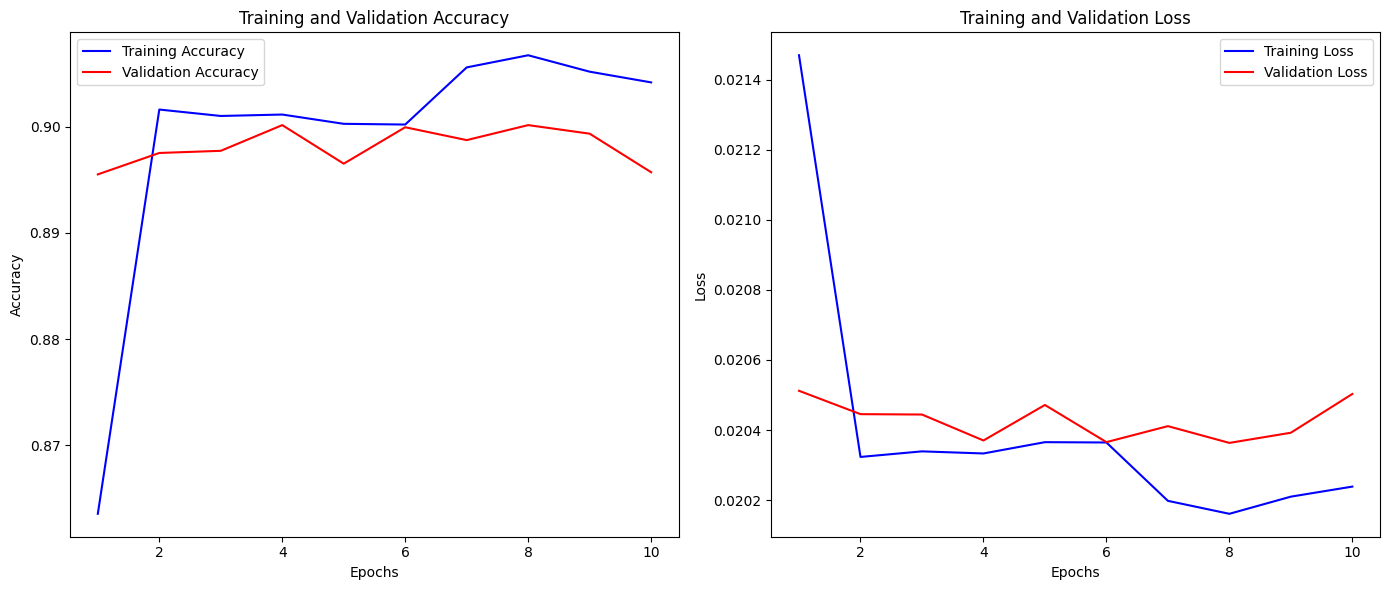

In [33]:
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'b', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Inference

In [34]:
import os
print(os.listdir())

['best_model_state.bin', '__notebook__.ipynb']


In [35]:
# Initialize the model with the same architecture
gpt2_model = GPTModel(num_labels)  # Ensure GPTModel is defined correctly
gpt2_model = gpt2_model.to(device)

# Load the state dict
best_model_name = 'best_model_state.bin'  # Replace with actual filename
gpt2_model.load_state_dict(torch.load(best_model_name))


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [36]:
def predict(model, data_loader):
    model.eval()
    all_predictions = []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_id'].to(device)
            attention_masks = d['attention_mask'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_masks)
            _, preds = torch.max(outputs, dim=1)
            all_predictions.extend(preds.cpu().numpy())
    
    return all_predictions

# Make predictions
predictions = predict(gpt2_model, test_loader)


In [37]:
test_data['predictions']=predictions

In [38]:
test_data

,clean_text,labels,predictions
0,rt there is a gift shop at the 911 museum and...,1,1
1,i need some red green amp yellow pants amp he...,2,2
2,this the onert hoes dont be wantin ya nigga t...,1,1
3,i can turn yo bitch into a eaterrrrrrrrr,1,1
4,rt smh u got ebola now rt i stick my foot out...,1,1
...,...,...,...
4952,because of the message that sends to lgbtq res...,1,2
4953,bruh this niggah always falls asleep,1,1
4954,were out here and were queer\n 2 4 6 hut we li...,0,1
4955,rt why give a bitch ya heart when she rather ...,1,1


In [39]:
from sklearn.metrics import classification_report
print(classification_report(test_data['labels'],test_data['predictions']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       286
           1       0.92      0.96      0.94      3838
           2       0.79      0.92      0.85       833

    accuracy                           0.90      4957
   macro avg       0.57      0.63      0.60      4957
weighted avg       0.85      0.90      0.87      4957



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
